In [1]:
import sys
import logging
import pickle
import numpy as np
import pandas as pd
from pandas.core.common import flatten

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# filter out tf warnings - training in a loop causes a retracing efficiency warning
tf.get_logger().setLevel(logging.ERROR)

# Add parent directory to path to allow import of config.py
sys.path.append("..")

import config as conf

In [2]:
data = pd.read_csv(f'{conf.DATA_PATH}{conf.FORMATTED_DATAFILE}')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Census Enrollment                14 non-null     float64
 1   Census Fill Rate                 14 non-null     float64
 2   Count of Migrated Data           14 non-null     float64
 3   Current Enrollment               14 non-null     float64
 4   Current Fill Rate                14 non-null     float64
 5   Enrollment Capacity              14 non-null     float64
 6   Ftef                             14 non-null     float64
 7   Ftes                             14 non-null     float64
 8   Ftes/Ftef                        14 non-null     float64
 9   Number Retained                  14 non-null     float64
 10  Number Successful                14 non-null     float64
 11  Retention Rate                   14 non-null     float64
 12  Sec. Count              

In [3]:
# Split data randomly into training and testing sets
training_data = data.sample(frac=conf.TRAIN_TEST_SPLIT)
test_data = data.drop(training_data.index)

# Seperate dependent and independent variable
training_features = training_data.copy()
test_features = test_data.copy()

training_labels = training_features.pop(conf.TARGET_VARIABLE)
test_labels = test_features.pop(conf.TARGET_VARIABLE)

In [4]:
# Setup normalization layer for features
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(training_features))

In [5]:
# Build and compile deep neural network model
DNN_model = keras.Sequential([
    normalizer,
    layers.Dense(conf.UNITS, activation='relu'),
    layers.Dense(conf.UNITS, activation='relu'),
    layers.Dense(conf.UNITS, activation='relu'),
    layers.Dense(1)
])

DNN_model.compile(
    loss='mean_absolute_error',
    optimizer=tf.keras.optimizers.Adam(conf.LEARNING_RATE)
)

DNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 23)                47        
_________________________________________________________________
dense (Dense)                (None, 128)               3072      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 36,272
Trainable params: 36,225
Non-trainable params: 47
_________________________________________________________________


In [6]:
%%time
# Do training run

history = DNN_model.fit(
    training_features, 
    training_labels,
    verbose=0,
    epochs=conf.TRAINING_EPOCHS
)

CPU times: user 1.11 s, sys: 122 ms, total: 1.23 s
Wall time: 1.36 s


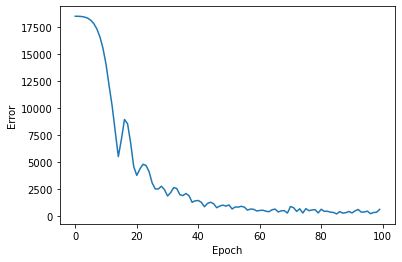

In [7]:
# Plot training data loss during training
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

In [8]:
# Score model on test data
test_score = DNN_model.evaluate(test_features, test_labels, verbose=0)
print(f'Test MAE: {int(test_score)}')

Test MAE: 2028


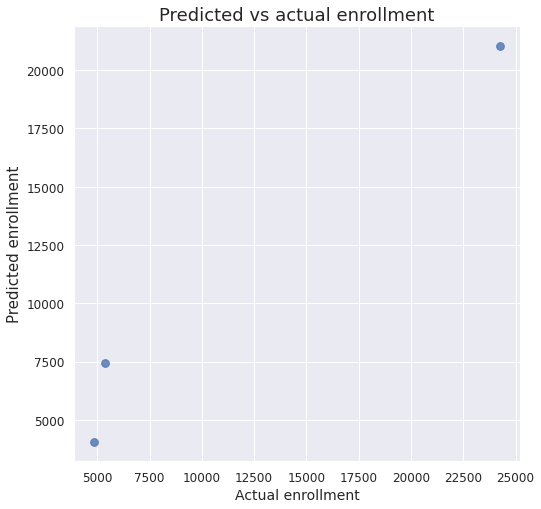

In [9]:
# Use model to predict enrollment for test dataset
predicted_enrollment = DNN_model.predict(test_features)

# Grab actual enrollment numbers to compare with
actual_enrollment = test_labels

# Plot actual enrollment vs predicted enrollment
sns.set(rc={'figure.figsize':(8,8)})

ax = sns.regplot(
    y=predicted_enrollment, 
    x=actual_enrollment, 
    fit_reg=False, 
    ci=False, 
    scatter_kws={'s':60}
)

ax.tick_params(labelsize=12)
ax.set_title('Predicted vs actual enrollment', fontsize=18)
ax.set_xlabel('Actual enrollment', fontsize=14)
ax.set_ylabel('Predicted enrollment', fontsize=15)
# ax.set_xlim(3000, 27000)
# ax.set_ylim(3000, 27000)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Looks pretty good! Still very worried about overfitting with such a small dataset. To augment this approach I am going to try something a little unconventional - bootstrap aggregation! This dataset is so small and our network is so simple, training completes on the order of seconds. We will use the speed of training to our advantage and train multiple times with different randomly chosen subsets of the data. Then we will use the ensamble of trained networks to make predictions. It will make more sense when you see it (I hope)...

First thing is to encapsulate the major opperations above into functions so we can easily build and train models in a loop.

In [10]:
def create_datasets(data, training_data_fraction, label_column_name):
    '''Takes master data as pandas dataframe splits into train and
    test features and labels, returns a dict of dataframes'''
    
    # Split data randomly into training and testing sets
    training_data = data.sample(frac=training_data_fraction)
    test_data = data.drop(training_data.index)

    # Seperate dependent and independent variable
    training_features = training_data.copy()
    test_features = test_data.copy()

    training_labels = training_features.pop(label_column_name)
    test_labels = test_features.pop(label_column_name)
    
    dataset = {}
    dataset['training_features'] = training_features
    dataset['test_features'] = test_features
    dataset['training_labels'] = training_labels
    dataset['test_labels'] = test_labels
    
    return dataset

In [11]:
def create_normalization_layer(training_features):
    '''Takes a pandas dataframe, returns an adapted tf.keras
    normalization layer'''
    
    normalizer = preprocessing.Normalization()
    normalizer.adapt(np.array(training_features))
    
    return normalizer

In [12]:
def build_and_compile_model(normalizer, units, learning_rate):
    '''Take pre-adapted normalization layer and hyperparameters,
    return compiled neural network model'''
    
    DNN_model = keras.Sequential([
        normalizer,
        layers.Dense(units, activation='relu'),
        layers.Dense(units, activation='relu'),
        layers.Dense(units, activation='relu'),
        layers.Dense(1)
    ])

    DNN_model.compile(
        loss='mean_absolute_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate)
    )
    
    return DNN_model

In [13]:
# First make some empty lists to hold our history objects 
# and trained models

results = {}
results['test_scores'] = []
results['test_labels'] = []
results['test_features'] = []
results['test_predictions'] = []

training_history_objects = []
trained_DNN_models = []

# Outer training loop
for i in range(conf.N_MODELS):
    print(f'Training model {i}', end='\r')
    
    # Clear state
    tf.keras.backend.clear_session()
    
    # Make dataset
    dataset = create_datasets(
        data,
        conf.TRAIN_TEST_SPLIT,
        conf.TARGET_VARIABLE
    )
    
    # Adapt normalization layer
    normalizer = create_normalization_layer(dataset['training_features'])
    
    # Build model
    DNN_model = build_and_compile_model(
        normalizer,
        conf.UNITS,
        conf.LEARNING_RATE
    )
    
    # Train model
    history = DNN_model.fit(
        dataset['training_features'], 
        dataset['training_labels'],
        verbose=0,
        epochs=conf.TRAINING_EPOCHS
    )

    # Evaluate model
    test_score = DNN_model.evaluate(
        dataset['test_features'], 
        dataset['test_labels'],
        verbose=0
    )

    # Sanity check test set score
    if test_score < 10000:
        # Store results
        DNN_model.save(f'{conf.NEURAL_NETWORK_MODEL_ENSEMBLE_PATH}{i}')
        trained_DNN_models.append(DNN_model)
        training_history_objects.append(history)

        # Add test set score to list
        results['test_scores'].append(test_score)

        # Make predictions for test set
        predictions = DNN_model.predict(dataset['test_features'])

        # Add test set predictions and labels to list
        results['test_predictions'].extend(list(flatten(predictions)))
        results['test_labels'].extend(dataset['test_labels'])

Quick look at the training loss, just to be sure all the models are converging to a reasonable degree.

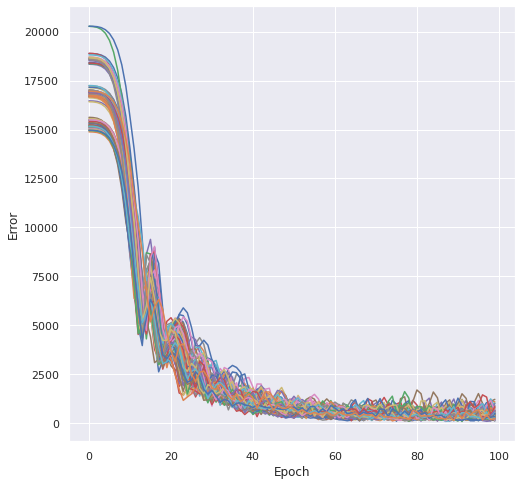

In [14]:
# Plot training data loss during training
for history in training_history_objects:
    plt.plot(history.history['loss'], label='loss')

plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

Let's plot the distribution of MAE scores for each randomly generated test set to see how we are doing.

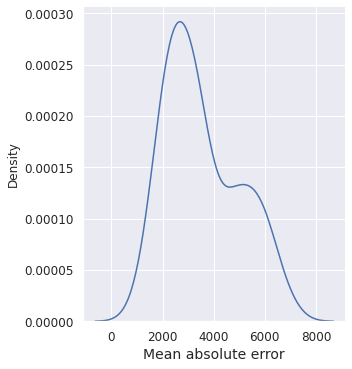

In [15]:
# Plot distribution of MAE scores from each model
sns.displot(results['test_scores'], kind="kde")
plt.tick_params(labelsize=12)
plt.xlabel('Mean absolute error', fontsize=14)

plt.show()

Still higher than I'd like - but much much better than the linear bagging model. There the error distribution had it's major peak around 10000 - and that was for predictions on the whole dataset (including training data) for each model. This distribution is true test set error for each model.

Now, let's take a look at the actual verses predicted values for the test sets.

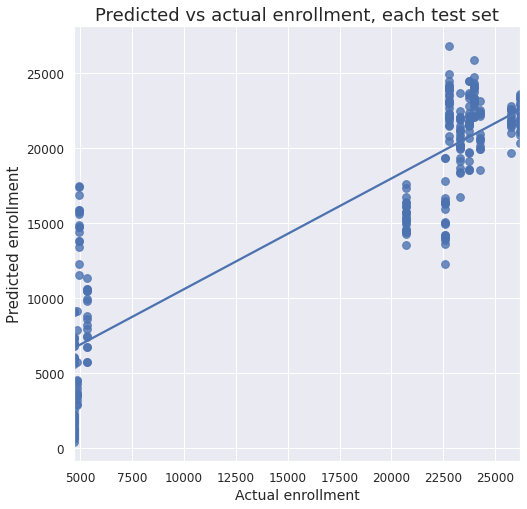

In [16]:
# Plot actual enrollment vs predicted enrollment
sns.set(rc={'figure.figsize':(8,8)})

ax = sns.regplot(
    y=results['test_predictions'], 
    x=results['test_labels'], 
    fit_reg=True, 
    ci=True, 
    scatter_kws={'s':60}
)

ax.tick_params(labelsize=12)
ax.set_title('Predicted vs actual enrollment, each test set', fontsize=18)
ax.set_xlabel('Actual enrollment', fontsize=14)
ax.set_ylabel('Predicted enrollment', fontsize=15)
# ax.set_xlim(3000, 27000)
# ax.set_ylim(3000, 27000)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Not too bad. Now let's try using the ensamble of models to make predictions. Strategy will be to loop through the list of trained models and use each to make a prediction vector, then average the vectors.

In [17]:
# Split master data into features and labels
X = data.drop(conf.TARGET_VARIABLE, axis=1)
y = data[conf.TARGET_VARIABLE]

# Empty list to hold predictions
predictions = []

for DNN_model in trained_DNN_models:
    predicted_enrollment = DNN_model.predict(X)
    predictions.append(predicted_enrollment)

# Average the predictions from each model
predicted_enrollment = np.mean(np.array(predictions), axis=0)

In [18]:
results['ensamble_predictions'] = predicted_enrollment
results['labels'] = y

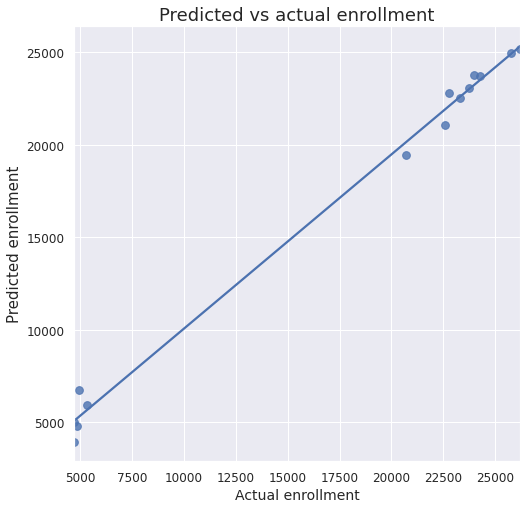

In [19]:
# Grab actual enrollment numbers to compare with
actual_enrollment = y

# Plot actual enrollment vs predicted enrollment
sns.set(rc={'figure.figsize':(8,8)})

ax = sns.regplot(
    y=predicted_enrollment, 
    x=actual_enrollment, 
    fit_reg=True, 
    ci=True, 
    scatter_kws={'s':60}
)

ax.tick_params(labelsize=12)
ax.set_title('Predicted vs actual enrollment', fontsize=18)
ax.set_xlabel('Actual enrollment', fontsize=14)
ax.set_ylabel('Predicted enrollment', fontsize=15)
# ax.set_xlim(4000, 27000)
# ax.set_ylim(4000, 27000)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

In [20]:
# Pick one semester to predict
single_semester = data.iloc[5]

# Seperate independent & dependent variables
X = single_semester.drop(conf.TARGET_VARIABLE)
X = np.array(X).reshape(1, -1)

y = single_semester[conf.TARGET_VARIABLE]

# Empty list to hold predictions
predictions = []

# Make prediction with each model
for DNN_model in trained_DNN_models:
    predicted_enrollment = DNN_model.predict(X)
    predictions.extend(predicted_enrollment[0])

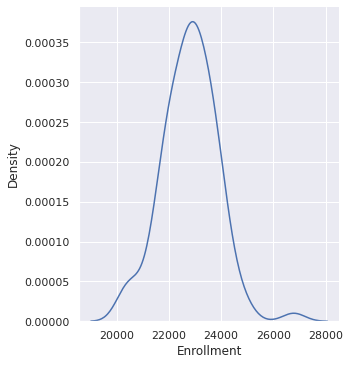

In [21]:
# Plot distribution of predictions from each model
sns.displot(predictions, kind="kde")
plt.xlabel('Enrollment')

plt.show()

In [22]:
import scipy.stats as st

mean = np.mean(predictions)
low, high = st.norm.interval(alpha=0.95, loc=np.mean(predictions), scale=st.sem(predictions))

print(f'Mean: {int(mean)}, 95% CI: {int(low)}-{int(high)}')
print(f'True value: {int(y)}')

Mean: 22804, 95% CI: 22588-23020
True value: 22781


In [23]:
# Save results
pkl_filename = f'{conf.RESULTS_PATH}{conf.NEURAL_NETWORK_RESULTS_FILE}'

with open(pkl_filename, 'wb') as file:
    pickle.dump(results, file)